## Downloading data

In [1]:
!wget https://raw.githubusercontent.com/minihat/Crypto-trade-bot/master/BTC_price_history.csv

--2020-06-09 11:21:16--  https://raw.githubusercontent.com/minihat/Crypto-trade-bot/master/BTC_price_history.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81871906 (78M) [text/plain]
Saving to: ‘BTC_price_history.csv’

BTC_price_history.c 100%[===================>]  78.08M  90.3MB/s    in 0.9s    

2020-06-09 11:21:21 (90.3 MB/s) - ‘BTC_price_history.csv’ saved [81871906/81871906]



In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

import torch
import torch.nn as nn
import torch.nn.functional as F

Preparing data

In [0]:
def generate_dataset(data, test_size):
    """
    Generates dataset assuming only one variable for prediction
    Here ahead starts at 1
    :return:
    """

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(data)
    data = scaler.transform(data)

    train_size = len(data)-test_size

    bitcoin_train = data[:train_size, :]
    train_x, train_y = bitcoin_train[:, :-1], bitcoin_train[:, -1]

    bitcoin_test = data[train_size:, :]
    test_x, test_y = bitcoin_test[:, :-1], bitcoin_test[:,  -1]

    return train_x, train_y, test_x, test_y, scaler


In [26]:
dataframe = pd.read_csv("BTC_price_history.csv", 
                        names=["Timestamp", "Low", "High", "Open", "Close", "Volume", "WeightedPrice"])
dataframe = dataframe.drop(columns=['Timestamp'])
dataframe.head(5)

,Low,High,Open,Close,Volume,WeightedPrice
0,300.0,300.0,300.0,300.0,0.010000,300.0
1,300.0,300.0,300.0,300.0,0.010000,300.0
2,370.0,370.0,370.0,370.0,0.010000,370.0
3,370.0,370.0,370.0,370.0,0.026556,370.0
4,377.0,377.0,377.0,377.0,0.010000,377.0


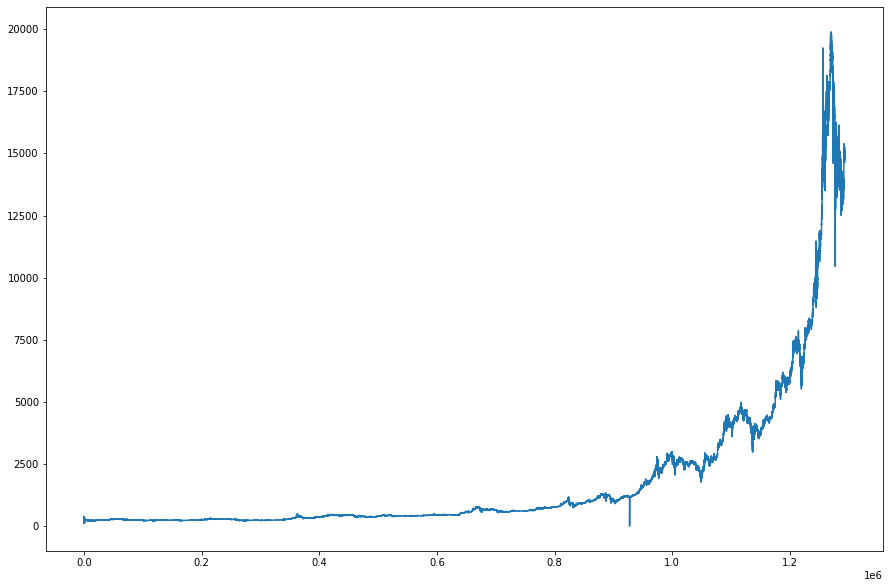

In [27]:
plt.figure(figsize=(15, 10))
dataframe.WeightedPrice.plot()

In [29]:
data_raw = dataframe.to_numpy()
test_size = 80000
# as data seems linear to 0.5, we omit that to focus on the challenges!
train_x, train_y, test_x, test_y, scaler = generate_dataset(data_raw[500000:, :], int(test_size))
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(713167, 5)
(713167,)
(80000, 5)
(80000,)


Constructing Tensor dataset

In [0]:
train_x = torch.as_tensor(train_x.astype(np.float32)).cuda()
train_y = torch.as_tensor(train_y.astype(np.float32)).cuda()
test_x = torch.as_tensor(test_x.astype(np.float32)).cuda()
test_y = torch.as_tensor(test_y.astype(np.float32)).cuda()

In [0]:
train = torch.utils.data.TensorDataset(train_x, train_y)
test = torch.utils.data.TensorDataset(test_x, test_y)

batch_size = len(train)

train_loader = torch.utils.data.DataLoader(dataset=train, 
                                           batch_size=batch_size, 
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test, 
                                          batch_size=batch_size, 
                                          shuffle=False)

## Architecture

In [32]:
class Regressor(nn.Module):
    def __init__(self, input_dim=5, hidden_dim=3, target_size=1):
        super(Regressor, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, target_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model = Regressor().cuda()
inputs = train_x[0:10]
preds = model(inputs)
preds.shape

torch.Size([10, 1])

In [33]:
loss_function = torch.nn.MSELoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

num_epochs = 100

hist = np.zeros(num_epochs)

# training
model.train()
for epoch in range(num_epochs):  
    for idx, (inputs, labels) in enumerate(train_loader):
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        inputs_in = inputs
        targets = labels.reshape(-1, 1)

        # Step 3. Run our forward pass.
        preds = model(inputs_in)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(preds, targets)
        
    if epoch % 1 == 0:
        print("Epoch ", epoch+1, "MSE: ", loss.item())
        hist[epoch] = loss.item()   

        loss.backward()
        optimizer.step()

Epoch  1 MSE:  0.16293178498744965
Epoch  2 MSE:  0.14956484735012054
Epoch  3 MSE:  0.1362605094909668
Epoch  4 MSE:  0.12306306511163712
Epoch  5 MSE:  0.11004678905010223
Epoch  6 MSE:  0.09729699790477753
Epoch  7 MSE:  0.0848998948931694
Epoch  8 MSE:  0.07294149696826935
Epoch  9 MSE:  0.06150311604142189
Epoch  10 MSE:  0.05068469047546387
Epoch  11 MSE:  0.04059106856584549
Epoch  12 MSE:  0.031381916254758835
Epoch  13 MSE:  0.023214101791381836
Epoch  14 MSE:  0.016299035400152206
Epoch  15 MSE:  0.010827619582414627
Epoch  16 MSE:  0.007070125080645084
Epoch  17 MSE:  0.005195791367441416
Epoch  18 MSE:  0.00521421292796731
Epoch  19 MSE:  0.006872224621474743
Epoch  20 MSE:  0.009540308266878128
Epoch  21 MSE:  0.012312056496739388
Epoch  22 MSE:  0.014387790113687515
Epoch  23 MSE:  0.015352228656411171
Epoch  24 MSE:  0.015176440589129925
Epoch  25 MSE:  0.01409215945750475
Epoch  26 MSE:  0.01244809664785862
Epoch  27 MSE:  0.010596474632620811
Epoch  28 MSE:  0.00882391

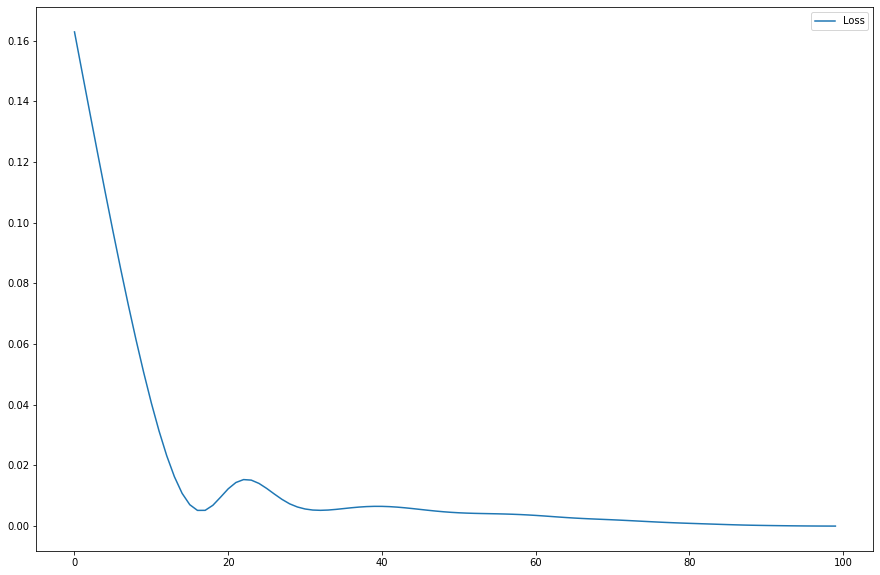

In [34]:
plt.figure(figsize=(15, 10))
plt.plot(np.arange(0, num_epochs), hist, label='Loss')
plt.legend()

In [35]:
model.eval()
with torch.no_grad():
    preds = model(test_x)
    loss = loss_function(preds, test_y.reshape(-1, 1))
    print('loss', loss.item())
test_rescaled = scaler.inverse_transform(np.concatenate((test_x.cpu().numpy(), test_y.cpu().reshape(-1, 1).numpy()), axis=1))[:,-1]
preds_rescaled = scaler.inverse_transform(np.concatenate((test_x.cpu().numpy(), preds.cpu().numpy()), axis=1))[:,-1]

loss 0.0016577319474890828


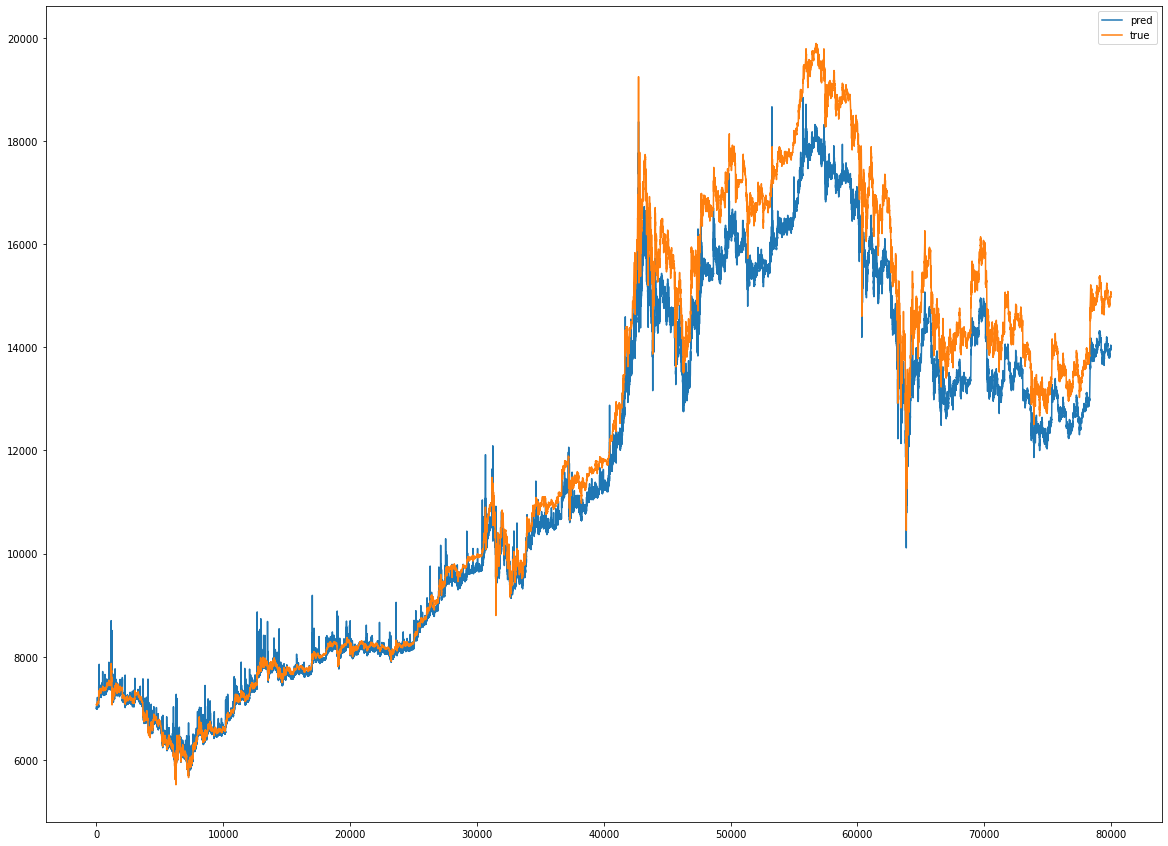

In [36]:
plt.figure(figsize=(20, 15))
plt.plot(np.arange(0, len(preds_rescaled)), preds_rescaled, label='pred')
plt.plot(np.arange(0, len(preds_rescaled)), test_rescaled, label='true')
plt.legend()

In [37]:
model.eval()
with torch.no_grad():
    preds = model(train_x)
    loss = loss_function(preds, train_y.reshape(-1, 1))
    print('loss', loss.item())
train_rescaled = scaler.inverse_transform(np.concatenate((train_x.cpu().numpy(), train_y.cpu().reshape(-1, 1).numpy()), axis=1))[:,-1]
preds_rescaled = scaler.inverse_transform(np.concatenate((train_x.cpu().numpy(), preds.cpu().numpy()), axis=1))[:,-1]

loss 1.799054371076636e-05


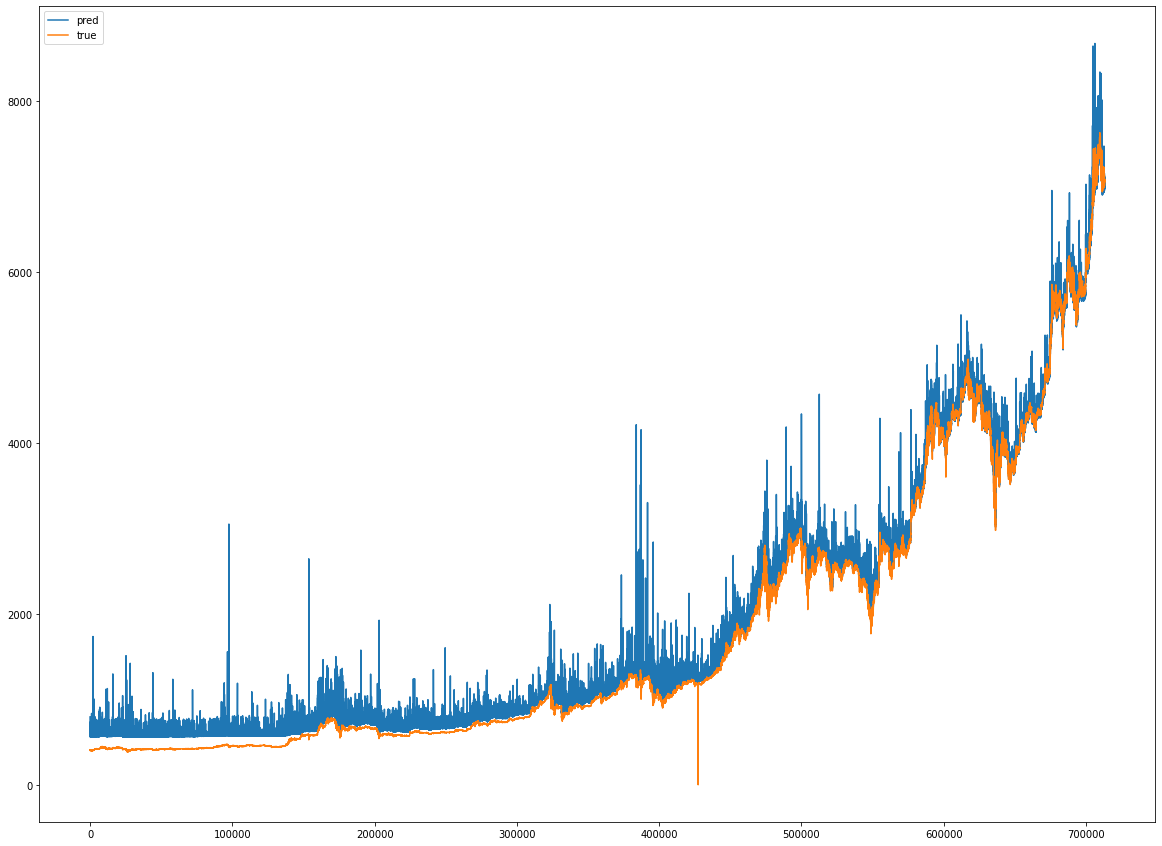

In [38]:
plt.figure(figsize=(20, 15))
plt.plot(np.arange(0, len(preds_rescaled)), preds_rescaled, label='pred')
plt.plot(np.arange(0, len(preds_rescaled)), train_rescaled, label='true')
plt.legend()